In [ ]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from skimage import io
import skimage
import time
from PIL import Image
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import sklearn.metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/ImageDataset/archive.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/ImageDataset/archive.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


###b
Pre-processing of each dataset


In [ ]:
buildingPath = '/content/seg_train/seg_train/buildings/*.jpg' #Building = 0
forestPath = '/content/seg_train/seg_train/forest/*.jpg'      #forest =   1
glacierPath = '/content/seg_train/seg_train/glacier/*.jpg'    #glacier =  2
seaPath = '/content/seg_train/seg_train/sea/*.jpg'            #sea =      3
streetPath = '/content/seg_train/seg_train/street/*.jpg'      #street =   4
mountainPath = '/content/seg_train/seg_train/mountain/*.jpg'  #mountain = 5


buildingPathTest = '/content/seg_test/seg_test/buildings/*.jpg' #Building = 0
forestPathTest = '/content/seg_test/seg_test/forest/*.jpg'      #forest =   1
glacierPathTest = '/content/seg_test/seg_test/glacier/*.jpg'    #glacier =  2
seaPathTest = '/content/seg_test/seg_test/sea/*.jpg'            #sea =      3
streetPathTest = '/content/seg_test/seg_test/street/*.jpg'      #street =   4
mountainPathTest = '/content/seg_test/seg_test/mountain/*.jpg'  #mountain = 5

In [ ]:
print(buildingPath)

/content/seg_train/seg_train/buildings/*.jpg


In [ ]:
def toGrey(fname,value,TT,**kwargs):
  im = skimage.io.imread(fname, as_gray=True)
  im = skimage.transform.resize(im, (100,100))
  im = np.array(im).flatten()
  im = np.append(im, TT)
  im = np.append(im, value)
  return im
##Train Data
buildingTrain = io.ImageCollection(buildingPath, load_func=toGrey, value = 0, TT = 0) #TT = 0 --> Training Set, TT = 1 --> Testing Set
forestTrain = io.ImageCollection(forestPath, load_func=toGrey, value = 1, TT = 0)
glacierTrain = io.ImageCollection(glacierPath, load_func=toGrey, value = 2, TT = 0)
seaTrain = io.ImageCollection(seaPath, load_func=toGrey, value = 3, TT = 0)
streetTrain = io.ImageCollection(streetPath, load_func=toGrey, value = 4, TT = 0)
mountainTrain = io.ImageCollection(mountainPath, load_func=toGrey, value = 5, TT = 0)

buildingTrain = io.concatenate_images(buildingTrain)
forestTrain = io.concatenate_images(forestTrain)
glacierTrain = io.concatenate_images(glacierTrain)
seaTrain = io.concatenate_images(seaTrain)
streetTrain = io.concatenate_images(streetTrain)
mountainTrain = io.concatenate_images(mountainTrain)

buildingTrain = pd.DataFrame(buildingTrain)
forestTrain = pd.DataFrame(forestTrain)
glacierTrain = pd.DataFrame(glacierTrain)
seaTrain = pd.DataFrame(seaTrain)
streetTrain = pd.DataFrame(streetTrain)
mountainTrain = pd.DataFrame(mountainTrain)




In [ ]:
buildingTest = io.ImageCollection(buildingPathTest, load_func=toGrey, value = 0, TT = 1)
forestTest = io.ImageCollection(forestPathTest, load_func=toGrey, value = 1, TT = 1)
glacierTest = io.ImageCollection(glacierPathTest, load_func=toGrey, value = 2, TT = 1)
seaTest = io.ImageCollection(seaPathTest, load_func=toGrey, value = 3, TT = 1)
streetTest = io.ImageCollection(streetPathTest, load_func=toGrey, value = 4, TT = 1)
mountainTest = io.ImageCollection(mountainPathTest, load_func=toGrey, value = 5, TT = 1)

buildingTest = io.concatenate_images(buildingTest)
forestTest = io.concatenate_images(forestTest)
glacierTest = io.concatenate_images(glacierTest)
seaTest = io.concatenate_images(seaTest)
streetTest = io.concatenate_images(streetTest)
mountainTest = io.concatenate_images(mountainTest)

buildingTest = pd.DataFrame(buildingTest)
forestTest = pd.DataFrame(forestTest)
glacierTest = pd.DataFrame(glacierTest)
seaTest = pd.DataFrame(seaTest)
streetTest = pd.DataFrame(streetTest)
mountainTest = pd.DataFrame(mountainTest)



In [ ]:
frames = [buildingTrain[0:2190], forestTrain[0:2190], glacierTrain[0:2190], seaTrain[0:2190], streetTrain[0:2190], mountainTrain[0:2190], \
          buildingTest, forestTest, glacierTest, seaTest, streetTest, mountainTest]
data = pd.concat(frames, ignore_index=True)


Y = data.loc[:,data.shape[1]-1]
TT_C = data.loc[:,data.shape[1]-2]
print("Total", data.shape)
print(Y.value_counts())
print(TT_C.value_counts())

'''
testX = pd.concat(framesTest, ignore_index=True)
testX = testX.sample(frac=1).reset_index(drop=True)
testX = testX.sample(frac=1).reset_index(drop=True)
testY = testX.loc[:,testX.shape[1]-1]
print("TEST", testX.shape)
print(testY.value_counts())
'''


Total (16140, 10002)
2.0    2743
5.0    2715
3.0    2700
4.0    2691
1.0    2664
0.0    2627
Name: 10001, dtype: int64
0.0    13140
1.0     3000
Name: 10000, dtype: int64


'\ntestX = pd.concat(framesTest, ignore_index=True)\ntestX = testX.sample(frac=1).reset_index(drop=True)\ntestX = testX.sample(frac=1).reset_index(drop=True)\ntestY = testX.loc[:,testX.shape[1]-1]\nprint("TEST", testX.shape)\nprint(testY.value_counts())\n'

I am importing all the images using Skimage because it offers ImageCollection making it very easy to work with. When I import the images, I pass in  function and resize all images to 100x100 so I have equal number of attributes for all images and change it to greyscale to reduce the number the parameters. Sampling all data at random to shuffle. I am centering and normalizing the data using Standard Scaler but its in the cell c (Compilation took too long so I didn't want to move it)

###a  
Brief exploration of each dataset

Total Number of Images:  16140
Total Number of features before feature Extraction (per Image):  10002
2.0    2743
5.0    2715
3.0    2700
4.0    2691
1.0    2664
0.0    2627
Name: 10001, dtype: int64


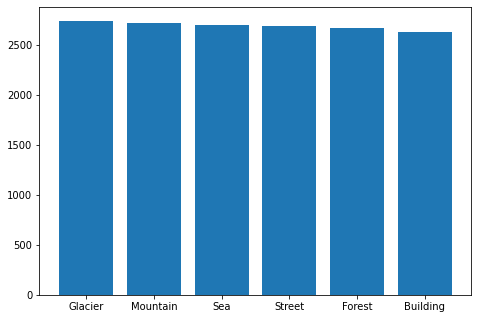

In [ ]:
print("Total Number of Images: ", data.shape[0])
print("Total Number of features before feature Extraction (per Image): ", data.shape[1]) #After Rescaling all images 
fig = plt.figure()
fig.xlabel = "Categories"
fig.ylabel = "Number of Samples"
ax = fig.add_axes([0,0,1,1])
labels = ['Glacier', 'Mountain', 'Sea', 'Street', 'Forest', 'Building']
print(Y.value_counts(sort=True))
ax.bar(labels, Y.value_counts(sort = True))
plt.show()



This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

I am using an equal number of images for all sets to keep uniform prior distribution. Rescaling the images to 100x100 and flattening it to keep equal parameters. So there are no missing values.

###c
Feature extraction / feature learning from each dataset

In [ ]:
total = data.drop(columns=[data.shape[1]-1, data.shape[1] - 2])
print(total)

scaler = StandardScaler()
X = scaler.fit_transform(total)
total = pd.DataFrame(X)

pca = PCA(0.95, svd_solver='full').fit(total)
total_data = pca.transform(total)
print(total_data.shape)

SavePath = '/content/drive/My Drive/Colab Notebooks/ImageDataset/'
np.save(SavePath+'pcaTrain', pca)

           0         1         2     ...      9997      9998      9999
0      0.967326  0.970266  0.972719  ...  0.143280  0.119280  0.202307
1      0.329706  0.840325  0.819388  ...  0.570323  0.645601  0.575988
2      0.626257  0.629932  0.640462  ...  0.038953  0.051730  0.045848
3      0.817343  0.883831  0.775641  ...  0.579228  0.574575  0.570169
4      0.654817  0.649991  0.622085  ...  0.071533  0.067615  0.060267
...         ...       ...       ...  ...       ...       ...       ...
16135  0.246147  0.246147  0.246006  ...  0.656579  0.723684  0.749103
16136  0.434887  0.432683  0.428764  ...  0.230061  0.313312  0.232513
16137  0.900375  0.900375  0.899640  ...  0.100261  0.104683  0.110563
16138  0.680087  0.680087  0.680087  ...  0.593846  0.606889  0.716585
16139  0.699978  0.695038  0.703890  ...  0.108608  0.120443  0.129997

[16140 rows x 10000 columns]
(16140, 1950)


In [ ]:
np.save(SavePath+'pca_trainX', total_data)
total_data = pd.DataFrame(total_data)
print(total_data)

            0           1          2     ...      1947      1948      1949
0      84.094933  -71.405142   7.331012  ... -0.286883  0.510156  0.177273
1      14.380790   26.839168 -22.041358  ... -0.597269  0.737829 -0.659763
2      30.250225  -14.342270   3.286524  ... -0.209217  0.273926 -0.145134
3      -4.738726   23.887172  -1.019457  ... -0.248144  1.540336  0.088652
4     -32.411323  -53.433880  25.537894  ...  0.116138  0.080925  0.059600
...          ...         ...        ...  ...       ...       ...       ...
16135   0.596846  115.678631  -3.351978  ... -0.765677 -0.481292 -0.301381
16136 -50.362508    0.092300  -5.934529  ... -0.320394 -0.171646 -0.007751
16137  65.178590  -47.350085  43.598028  ... -0.177425  0.055400 -0.036300
16138  39.538768  -25.863124   5.520056  ... -0.232658 -0.044792  0.450483
16139  88.220929  -32.448569  75.095480  ...  0.345194  0.114486  0.458590

[16140 rows x 1950 columns]


In [ ]:
total = pd.concat([total_data, TT_C], axis=1) 
trainX = total.loc[total[10000] == 0] #index 10000 --> 0 - Training, 1 - Test
trainY = Y.loc[total[10000] == 0]
trainX = pd.DataFrame(trainX)
trainY = pd.DataFrame(trainY)

testX = total.loc[total[10000] == 1]
testY = Y.loc[total[10000] == 1]
testX = pd.DataFrame(testX)
testY = pd.DataFrame(testY)

trainX = trainX.drop(columns=[10000])
testX = testX.drop(columns=[10000])

trainX = pd.concat([trainX, trainY], axis = 1)
testX = pd.concat([testX, testY], axis = 1)

print(trainX)
print(testX)

           0          1          2      ...     1948      1949   10001
0      84.094933 -71.405142   7.331012  ...  0.510156  0.177273    0.0
1      14.380790  26.839168 -22.041358  ...  0.737829 -0.659763    0.0
2      30.250225 -14.342270   3.286524  ...  0.273926 -0.145134    0.0
3      -4.738726  23.887172  -1.019457  ...  1.540336  0.088652    0.0
4     -32.411323 -53.433880  25.537894  ...  0.080925  0.059600    0.0
...          ...        ...        ...  ...       ...       ...    ...
13135  78.616287 -75.524537  16.964950  ...  0.623296  0.305074    5.0
13136  39.680810 -26.237029  54.586163  ...  0.191272  0.215040    5.0
13137 -32.583341 -40.290583  -3.004741  ... -0.075517 -0.277119    5.0
13138  26.338133 -36.087838  25.059227  ...  0.551025 -0.158878    5.0
13139  -2.223373 -39.793041  45.053218  ... -0.073029 -0.594586    5.0

[13140 rows x 1951 columns]
           0           1          2      ...     1948      1949   10001
13140  48.581204    1.100303   9.868539  ...  0

In [ ]:
trainX = trainX.sample(frac=1).reset_index(drop=True)
trainX = trainX.sample(frac=1).reset_index(drop=True)
trainY = trainX.loc[:,10001] #
trainX = trainX.drop(columns=[10001])

testX = testX.sample(frac=1).reset_index(drop=True)
testX = testX.sample(frac=1).reset_index(drop=True)
testY = testX.loc[:,10001]
testX = testX.drop(columns = [10001])


There are no invalid or missing entries since the pixels are being flattened so its getting the original values from the image and all these values are greater than one becuase image is encoded in RGB (0-255) and then converted to grayscale so we need to standardize the data to prevent extreme weights to one column than others and same for all images. Also, PCA requires centered data so standardizing was necessary for feature extraction. Standardizing had to be done over the entire dataset so had to combine all data before training during the preproccesing state and use PCA for feature extraction over all datasamples to avoid losing different parameters.

Using PCA to reduce the number of features to a number that covers 95% of the data. I applied PCA on training data and extracted same number of features on the test data. PCA was done to reduce the dimensionality and throw away components that are low variance (have no/minimal effect on dataset). Also, since we are working with large parameter size, PCA would help us from overfitting the data. 




###d

In [ ]:
pca_trainX = pd.DataFrame(trainX)
pca_testX = pd.DataFrame(testX)

######KNN


In [ ]:
KFolds = KFold(6)
KFolds.get_n_splits(pca_trainX)
kValues = [3,5,7,11,13,17]

KNN_Errors = 0
KNN_TrainingTimes = 0
KFolds.split(pca_trainX)
count = 0
error = []
for train_data, test_data in KFolds.split(pca_trainX):
  currentTime = time.time()
  X_train, X_test = pca_trainX.iloc[train_data], pca_trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]

  KNNClf = KNeighborsClassifier(n_neighbors=kValues[count],algorithm='brute', weights='distance', p=2, n_jobs = -1)
  KNNClf.fit(X_train, y_train)
  resultKNN = KNNClf.predict(X_test)
  KNN_TrainingTimes += sklearn.metrics.mean_squared_error(y_test, resultKNN)
  print("K: ", kValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultKNN), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultKNN))
  KNN_Errors += sklearn.metrics.mean_squared_error(y_test, resultKNN)
  count += 1
  KNN_TrainingTimes += time.time() - currentTime
  error.append(sklearn.metrics.mean_squared_error(y_test, resultKNN))

KNN_TrainingTimes /= 6
KNN_Errors /= 6

K:  3 Accuracy:  0.31917808219178084 Mean Squared Error:  4.570776255707763
K:  5 Accuracy:  0.32374429223744294 Mean Squared Error:  4.682191780821918
K:  7 Accuracy:  0.30776255707762556 Mean Squared Error:  4.65296803652968
K:  11 Accuracy:  0.32602739726027397 Mean Squared Error:  4.618264840182649
K:  13 Accuracy:  0.31643835616438354 Mean Squared Error:  4.763926940639269
K:  17 Accuracy:  0.3401826484018265 Mean Squared Error:  4.529680365296803


In [ ]:
KNNClf = KNeighborsClassifier(n_neighbors=17,algorithm='brute', weights='distance', p=2, n_jobs = -1)
KNNClf.fit(pca_trainX, trainY)
resultKNN = KNNClf.predict(pca_testX)
print("Production KNN Algorithm:")
print("K: ",17, " Accuracy: ", sklearn.metrics.accuracy_score(testY, resultKNN), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(testY, resultKNN))

KNN_TestError = sklearn.metrics.mean_squared_error(testY, resultKNN)

Production KNN Algorithm:
K:  17  Accuracy:  0.3313333333333333 Mean Squared Error:  4.399


######Logistic Regression

In [ ]:
#############Logistic Regression
from sklearn.linear_model import LogisticRegression
LR_TrainingTimes = 0
LR_TrainingError = 0

KFolds = KFold(6)
KFolds.get_n_splits(pca_trainX)
CValues = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
count = 0
for train_data, test_data in KFolds.split(pca_trainX):
  currentTime = time.time()
  X_train, X_test = pca_trainX.iloc[train_data], pca_trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  LogisticCLF = LogisticRegression(penalty = 'l2', tol = 0.1, C=CValues[count], solver='liblinear',max_iter = 2000, multi_class = 'ovr').fit(X_train, y_train)
  resultLR = LogisticCLF.predict(X_test)
  print("C:", CValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultLR), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultLR))
  LR_TrainingError +=  sklearn.metrics.mean_squared_error(y_test, resultLR)
  LR_TrainingTimes += time.time() - currentTime
  count += 1

LR_TrainingTimes /= 6
LR_TrainingError /= 6

C: 1 Accuracy:  0.3324200913242009 Mean Squared Error:  4.8342465753424655
C: 0.1 Accuracy:  0.32511415525114157 Mean Squared Error:  4.8123287671232875
C: 0.01 Accuracy:  0.34794520547945207 Mean Squared Error:  4.778082191780822
C: 0.001 Accuracy:  0.3917808219178082 Mean Squared Error:  4.315981735159817
C: 0.0001 Accuracy:  0.42191780821917807 Mean Squared Error:  4.039269406392694
C: 1e-05 Accuracy:  0.44018264840182647 Mean Squared Error:  4.233333333333333


In [ ]:
tolValues = [1, 0.1, 0.01, 0.001, 0.00001, 0.000001]
count = 0
temp = 0
temp2 = 0
for train_data, test_data in KFolds.split(pca_trainX):
  currentTime = time.time()
  X_train, X_test = pca_trainX.iloc[train_data], pca_trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  LogisticCLF = LogisticRegression(penalty = 'l2', tol = tolValues[count], C=0.0001, solver='liblinear',max_iter = 2000, multi_class = 'ovr').fit(X_train, y_train)
  resultLR = LogisticCLF.predict(X_test)
  print("tol:", tolValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultLR), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultLR))
  temp += time.time() - currentTime
  temp2 += sklearn.metrics.mean_squared_error(y_test, resultLR)
  count += 1

LR_TrainingTimes += temp/6
LR_TrainingTimes /= 2 
LR_TrainingError += temp2/6
LR_TrainingError /= 2

tol: 1 Accuracy:  0.410958904109589 Mean Squared Error:  4.14703196347032
tol: 0.1 Accuracy:  0.42876712328767125 Mean Squared Error:  4.112328767123287
tol: 0.01 Accuracy:  0.4178082191780822 Mean Squared Error:  4.218721461187215
tol: 0.001 Accuracy:  0.43105022831050227 Mean Squared Error:  4.105479452054794
tol: 1e-05 Accuracy:  0.42420091324200915 Mean Squared Error:  3.99634703196347
tol: 1e-06 Accuracy:  0.4324200913242009 Mean Squared Error:  4.205479452054795


In [ ]:
LogisticCLF = LogisticRegression(penalty = 'l2', tol =  0.00001, C=0.0001, solver='liblinear',max_iter = 2000, multi_class = 'ovr').fit(pca_trainX, trainY)
resultLR = LogisticCLF.predict(pca_testX)
print("Production Logistic Regression Algorithm:")
print("Accuracy: ", sklearn.metrics.accuracy_score(testY, resultLR), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(testY, resultLR))

LR_TestError = sklearn.metrics.mean_squared_error(testY, resultLR)

Production Logistic Regression Algorithm:
Accuracy:  0.434 Mean Squared Error:  4.091666666666667


###### Radial Kernel SVM

In [ ]:
CValues = [10000, 100, 10, 1, 0.1, 0.001]
KFolds = KFold(6, shuffle=True)
SVM_TrainingTime = 0
SVM_TrainingError = 0
count = 0
for train_data, test_data in KFolds.split(pca_trainX):
  currentTime = time.time()
  X_train, X_test = pca_trainX.iloc[train_data], pca_trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  SVMClf = SVC(C=CValues[count], kernel = 'rbf' ,tol= 3 ,max_iter = 3000, decision_function_shape='ovr')
  SVMClf.fit(X_train, y_train)

  resultSVM = SVMClf.predict(X_test)
  print("C:", CValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultSVM), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultSVM))
  SVM_TrainingTime += time.time() - currentTime
  SVM_TrainingError += sklearn.metrics.mean_squared_error(y_test, resultSVM)
  count += 1


C: 10000 Accuracy:  0.16940639269406393 Mean Squared Error:  9.434703196347032
C: 100 Accuracy:  0.1726027397260274 Mean Squared Error:  9.057077625570777
C: 10 Accuracy:  0.16529680365296803 Mean Squared Error:  9.140182648401826
C: 1 Accuracy:  0.16712328767123288 Mean Squared Error:  9.018264840182649
C: 0.1 Accuracy:  0.15844748858447488 Mean Squared Error:  9.189497716894977
C: 0.001 Accuracy:  0.16712328767123288 Mean Squared Error:  9.16027397260274


In [ ]:
tolValues = [100 , 10, 5, 1, 0.1, 0.099]
temp = 0
temp2 = 0

count = 0
for train_data, test_data in KFolds.split(pca_trainX):
  currentTime = time.time()
  X_train, X_test = pca_trainX.iloc[train_data], pca_trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  SVMClf = SVC(C=100, kernel = 'rbf' ,tol= tolValues[count],max_iter = 10000, decision_function_shape='ovr')
  SVMClf.fit(X_train, y_train)

  resultSVM = SVMClf.predict(X_test)
  print("C:",1000,'Tolerance: ', tolValues[count],  "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultSVM), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultSVM))
  temp += time.time() - currentTime
  temp2 += sklearn.metrics.mean_squared_error(y_test, resultSVM)
  count += 1

SVM_TrainingTime += temp
SVM_TrainingTime /= 12
SVM_TrainingError += temp2
SVM_TrainingError /= 12

C: 1000 Tolerance:  100 Accuracy:  0.17488584474885846 Mean Squared Error:  9.302739726027397
C: 1000 Tolerance:  10 Accuracy:  0.15844748858447488 Mean Squared Error:  9.126940639269407
C: 1000 Tolerance:  5 Accuracy:  0.1589041095890411 Mean Squared Error:  9.246118721461187
C: 1000 Tolerance:  1 Accuracy:  0.536986301369863 Mean Squared Error:  3.2881278538812784
C: 1000 Tolerance:  0.1 Accuracy:  0.5356164383561643 Mean Squared Error:  3.3621004566210044
C: 1000 Tolerance:  0.099 Accuracy:  0.5401826484018265 Mean Squared Error:  3.34337899543379


In [ ]:
SVMClf = SVC(C=100, kernel = 'rbf' ,tol= 1,max_iter = 10000, decision_function_shape='ovr')
SVMClf.fit(X_train, y_train)
resultSVM = SVMClf.predict(pca_testX)
print("C:", 100, "Accuracy: ", sklearn.metrics.accuracy_score(testY, resultSVM), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(testY, resultSVM))
SVM_TestError = sklearn.metrics.mean_squared_error(testY, resultSVM)

C: 100 Accuracy:  0.5343333333333333 Mean Squared Error:  3.3176666666666668


Used Kfold Validation to cross validate the regularization parameters and tolerance rate to minimize the errors in SVM and Logistic Regression. And used KFold for the k values in KNN. Used KNN to test performance with non-parametric classifier.

I also used brute algorithm for KNN with the weights of the neightbors inversely weighted by distance.

I used l2 penalty (Euclidian) with linear model for Logisitc Regression and to save time on training used One vs all classification. Logistic Regression was used to see the performance of a linear classifier that does not require  gaussian distribution.

Used radial kernel SVM since the data is spread out on so many dimensions and finding a linear relation would be very inaccurate. Also used One vs all to save time on training and testing. Used Radial Kernel SVM to see performance under a non-linear kernel. And given thats its a image dataset with large number of parameters, I expected this algorithm to outperform the others.

###e

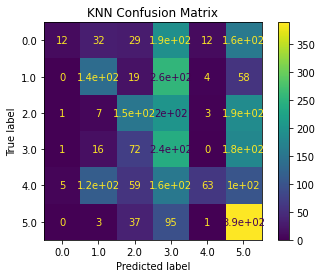

In [ ]:
confusion_matrix = sklearn.metrics.plot_confusion_matrix(KNNClf, pca_testX, testY)
plt.title("KNN Confusion Matrix")
plt.show()

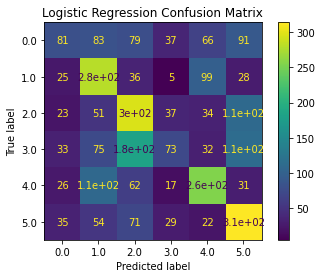

In [ ]:
confusion_matrix = sklearn.metrics.plot_confusion_matrix(LogisticCLF, pca_testX, testY)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

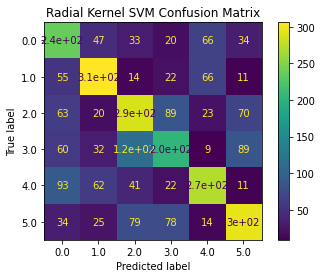

In [ ]:
confusion_matrix = sklearn.metrics.plot_confusion_matrix(SVMClf, pca_testX, testY)
plt.title("Radial Kernel SVM Confusion Matrix")
plt.show()

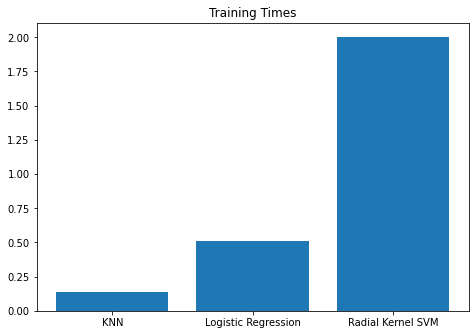

In [ ]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
labels = ['KNN', 'Logistic Regression', 'Radial Kernel SVM']
values = [KNN_TrainingTimes /60, LR_TrainingTimes /60, SVM_TrainingTime / 60]
plt.title("Training Times")
ax.bar(labels, values)
plt.show()



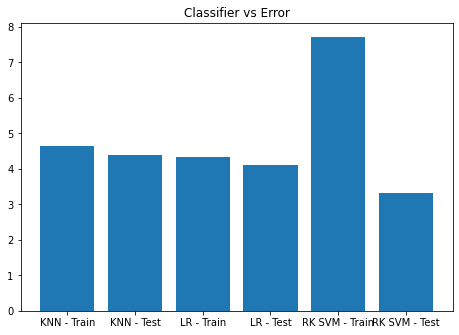

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['KNN - Train','KNN - Test', 'LR - Train', 'LR - Test',  'RK SVM - Train', 'RK SVM - Test']
values = [KNN_Errors, KNN_TestError, LR_TrainingError, LR_TestError, SVM_TrainingError, SVM_TestError]
ax.bar(labels, values)
plt.title('Classifier vs Error')
plt.show()

Confusion matrices, and Average Squared Mean Error are shown above. The classifiers did not perform the as well as I expected even with cross validation and preprocessing. SVM performed the best overall but it had the longest training time. LR came in second with relatively slower training times and KNN came in last. The Parametric classifiers seemed to have outperformed non-parametric classifier. And since it was an image dataset, I expected the radial kernel to outperform the remaining classifiers and it did that very well. COnfusion matrices shows that the KNN classifier set most of the labels to 3 and 5 with minimal label classification for 0,1, 2 and 4. I looked into it but I could not find why this was an issue (Will look into it on my own time later). TP, TN, FN, FP can clearly be seen under confusion matrices.

###f

Ethhical aspect of machine learning tasks for this dataset would exist while gathering the data. So, taking pictures of a prohibited property would raise a bunch of problems. Taking pictures of buildings could cause legal issues with taking pictures of buildings without owners permission, or government/military buildings in any country that could be posed as a security threat. For street pictures, it possible that there are cars present and then the number plates would reveal somones private information which they might not want to be shared. For mountains and forest, you could be disturbing the habitat by being around it or it could be possible that the law restricts entering the area for preservation. Sea pictures could raise issues with safety if on a boat and given thats its not international waters, the rules and regulations restricting traveling in their water bodies. 

###g

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

Weblinks:

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/neighbors.html#classification

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/svm.html#svm-classification

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


https://scikit-image.org/docs/0.7.0/api/skimage.io.html#concatenate-images

https://scikit-image.org/docs/0.7.0/api/skimage.io.collection.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://scikit-learn.org/stable/modules/svm.html#svm-kernels

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py



Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) https://doi.org/10.7717/peerj.453 

Weblinks:

https://scikit-image.org/docs/stable/api/skimage.io.html#imagecollection


https://scikit-image.org/docs/stable/api/skimage.io.html#concatenate-images